 Lab - Internet Meter Anomaly Detection

By Amizuku Francis 

Step 1: Import Python Libraries.

In [1]:
import numpy as np
import pandas as pd

Step 2: Create a Dataframe and modify the quantities.

In [3]:
#Code Cell 2
# Load internet speed data
df = pd.read_csv('rpi_data_processed.csv')

# Initialize dataframe df_rates
df_rates = df.drop(['Ping (ms)', 'Date', 'Time'], axis=1)

# Rename the download and
# upload columns of df_rates
lookup = {'Download (Mbit/s)': 'download_rate', 
          'Upload (Mbit/s)': 'upload_rate'}
df_rates = df_rates.rename(columns = lookup)

# Calculate ping_rate
ping_rate = 1. / df['Ping (ms)']

# Convert ping_rate to 1/seconds
ping_rate = 1000. * ping_rate

# Add a column to complete the task
df_rates['ping_rate'] = ping_rate

In [4]:
#Code Cell 3
# SOLUTION:
# Inspect the result
df_rates.describe()

,upload_rate,download_rate,ping_rate
count,673.000000,673.000000,673.000000
mean,13.697608,90.449212,48.657348
std,1.080471,3.465647,6.030512
min,6.210000,58.480000,13.067113
25%,13.640000,90.220000,45.781257
50%,13.980000,91.560000,49.207755
75%,14.180000,92.070000,52.314936
max,14.550000,92.870000,61.854395


Step 3: Visualize the Data.

In [5]:
# Code Cell 4
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

In [6]:
# Code Cell 5
def scatter_view(x, y, z, azim, elev):
    # Init figure and axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    # Compute scatter plot
    ax.scatter(x, y, z)
    ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
    ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
    ax.set_zlabel('P rate (1/s)', fontsize=16)
    
    # Specify azimuth
    # and elevation
    ax.azim = azim
    ax.elev = elev

In [7]:
# Code Cell 6
# Draw interactive plot
xi = df_rates['download_rate']
yi = df_rates['upload_rate']
zi = df_rates['ping_rate']
interact(lambda azim, elev: scatter_view(xi, yi, zi, azim, elev),
         azim=(0, 90), elev=(0, 90))
plt.show()

interactive(children=(IntSlider(value=45, description='azim', max=90), IntSlider(value=45, description='elev',…

Part 2: Euclidean Anomaly Detection

Step 1: Calculate the means.

In [8]:
# Code Cell 7
mu = df_rates.mean()

Step 2: Calculate the Euclidean distance.

In [9]:
# Code Cell 8
euclid_sq = np.square(df_rates - mu).sum(axis=1)
euclid = np.sqrt(euclid_sq)

Step 3: Create a histogram.

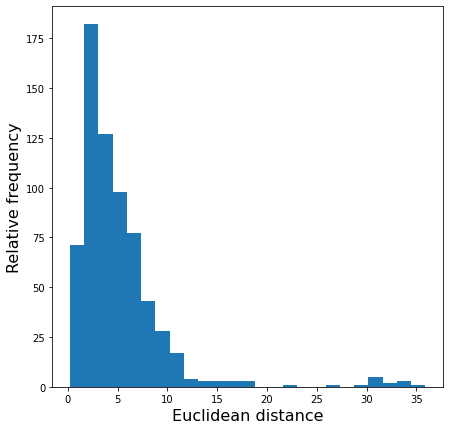

In [10]:
# Code Cell 9
# Histogram of Euclidean distance
fig = plt.figure(figsize=(7, 7))
#SOLUTION:
plt.hist(euclid, 25)

plt.xlabel('Euclidean distance', fontsize=16)
plt.ylabel('Relative frequency', fontsize=16)
plt.show()

Step 4: Compute the normalized distance.

In [11]:
# Code Cell 10
# Compute normalized Euclidean distance
# SOLUTION:
max_euclid = euclid.max()
nmd_euclid = [float(x)/max_euclid for x in euclid]

Step 5: Visualize the alarm rate.

In [12]:
# Code Cell 11
# Get alarm rate as a function
# of normalized decision distance
ecl_alarm_rate = []
nmd_range = np.linspace(0, 1, 400)
for nmd_decision in nmd_range:
    # Count the number of values with a higher euclidean distance than 
    # the current decision boundary 
    # SOLUTION:
    num_fail = (nmd_euclid > nmd_decision).sum()
    ecl_alarm_rate.append(float(num_fail) / len(euclid))

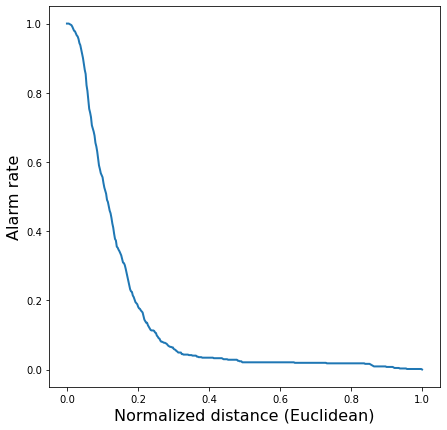

In [13]:
# Code Cell 12
# Plot number of alarms as a 
# function of decision distance
fig = plt.figure(figsize=(7, 7))
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)
plt.show()

Step 6: Select the decision boundary.

The plot above converts the problem of fixing a decision boundary in that of selecting the alarm rate. This is advantageous because the domain of application typically determines a sensible choice for the alarm rate. For example, when testing the safety of aeroplane engines, we may want to choose the alarm rate to be relatively high, so that both major and minor anomalies are detected, and the level of risk is kept low.

Assume that, for this specific use-case, the optimal alarm rate is 0.1. Find the smallest normalized decision distance (ecl_decision) so that the alarm rate falls strictly below the threshold. Because the alarm rate at the selected decision boundary will not be precisely 0.1, store the exact rate in the variable ecl_threshold.

In [14]:
# Code Cell 13
# Select decision boundary
threshold = 0.1
index, ecl_threshold = next(tpl for tpl in enumerate(ecl_alarm_rate) if tpl[1] < threshold)
ecl_decision = nmd_range[index]

Step 7: Visualize the decision boundary.

Generate the plot from step 5 again, using a dot to mark the location of the decision boundary.

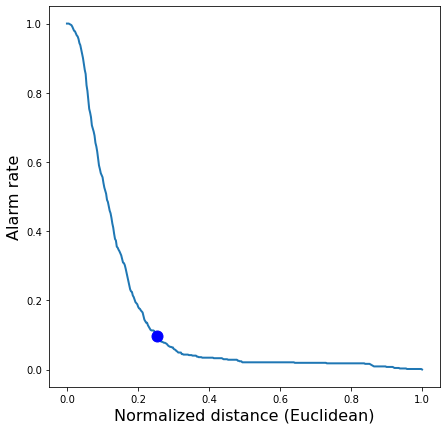

In [15]:
#Code Cell 14
# Alarm rate with decision boundary
fig = plt.figure(figsize=(7, 7))
# SOLUTION:
# Plot the alarm rate as a function of the normalized euclidean distance
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
# Plot the chosen decision threshold and the curresponding alarm rate
plt.plot(ecl_decision, ecl_threshold, 'bo', markersize=11)

plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)
plt.show()

Step 8: Visualize the decision boundary in 3D.

Because our anomaly detection algorithm makes use of Euclidean distances, its decision boundaries, when visualized in three dimensions, are spherical. Examine the plot below to see this. We would also encourage you to read and understand the associated code.

In [16]:
#Code Cell 15
# Decision sphere (Polar coordinates)
radius = ecl_decision * max_euclid
phi = np.linspace(0, 2 * np.pi, 300)
theta = np.linspace(0, 2 * np.pi, 300)

# Decision sphere (Cartesian coordinates)
xs = radius * np.outer(np.sin(theta), np.cos(phi))
ys = radius * np.outer(np.sin(theta), np.sin(phi))
zs = radius * np.outer(np.cos(theta), np.ones(np.size(phi)))

# Center decision sphere at mean
ecl_xd = xs + df_rates['download_rate'].mean()
ecl_yd = ys + df_rates['upload_rate'].mean()
ecl_zd = zs + df_rates['ping_rate'].mean()

C:\Users\A265820\AppData\Local\Temp\ipykernel_13916\4035236851.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


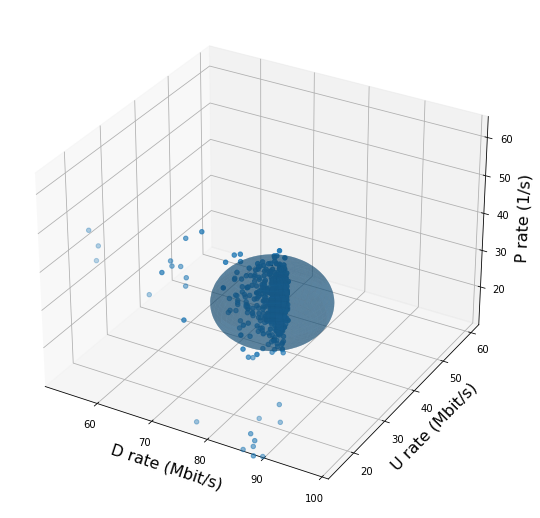

In [17]:
#Code Cell 16
# Init figure and axes
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig)

# Plot data
ax.scatter(df_rates['download_rate'],
           df_rates['upload_rate'], 
           df_rates['ping_rate'])

# Plot decision boundary
ax.plot_surface(ecl_xd, ecl_yd, ecl_zd,
                linewidth=0, alpha=0.25)

# Label axes
ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
ax.set_zlabel('P rate (1/s)', fontsize=16)
    
# --------------------------------------------------
# Set equal aspect ratio for all axes
# --------------------------------------------------

# Extreme values of x, y, z
extremes = []
extremes.append([df_rates['download_rate'].min(),
                 df_rates['download_rate'].max()])
extremes.append([df_rates['upload_rate'].min(),
                 df_rates['upload_rate'].max()])
extremes.append([df_rates['ping_rate'].min(),
                 df_rates['ping_rate'].max()])

# Half-widths and mid-points
hwidths = [(row[1] - row[0]) / 2.0 for row in extremes]
midpts = [(row[1] + row[0]) / 2.0 for row in extremes]

# Set xlim, ylim, zlim
left_ends = midpts - np.max(hwidths)
right_ends = midpts + np.max(hwidths)
ax.set_xlim([left_ends[0], right_ends[0]]);
ax.set_ylim([left_ends[1], right_ends[1]]);
ax.set_ylim([left_ends[2], right_ends[2]]);